In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.gridspec as gridspec
import random 
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols

%matplotlib inline
sns.set_context('talk', font_scale=0.5, rc={"axes.linewidth":1,
                                            "xtick.major.width":1,
                                            "ytick.major.width":1})

/tmp/ipykernel_2557487/520776295.py:8: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  import scipy
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [10]:
sequenced=[101,102,204,205,305,402,403,501,503,601,604,803,804,805,901,902,903,905,
           1001,1005,1101,1105,1201,1302,1401,1402,1403,1405,1503,1504,1505,1602]

### Functions for loading in raw data and converting into readable dataframe

In [2]:
def load_SI(filepath, cohort_num):
    '''
    Function for loading in SI test data from Ethovision CSV
    
    Inputs: 
    - filepath (str): filepath of Ethovision file
    - cohort (int): cohort number
    
    Outputs: pandas dataframe with relevant behavioral metrics
    '''
    # Load in raw data 
    full_df = pd.read_csv(filepath)
    mice = full_df['Mouse'].dropna().unique()

    data = []

    for m in mice:

        mdata = full_df[full_df['Mouse'] == m]

        empty_trial = mdata[mdata['Target'] == 'N'].squeeze()
        social_trial = mdata[mdata['Target'] == 'Y'].squeeze()
        
        group = social_trial.get('Group', np.nan)
        sex = social_trial.get('Sex', np.nan)
        
        distance_traveled = social_trial.get('Distance moved (cm)', np.nan)
        velocity = social_trial.get('Velocity (cm/s)', np.nan)

        empty_IZ_time = round(empty_trial.get('Cumulative Duration in IZ (s)', 0), 2)
        empty_corner_time = round(empty_trial.get('Cumulative Duration in all_corners (s)', 0), 2)

        social_IZ_time = round(social_trial.get('Cumulative Duration in IZ (s)', 0), 2)
        social_corner_time = round(social_trial.get('Cumulative Duration in all_corners (s)', 0), 2)

        latency_to_IZ = social_trial.get('Latency to First IZ (s)', 150)
        latency_to_IZ = 150 if latency_to_IZ == '-' else round(float(latency_to_IZ), 2)

        latency_to_corners = social_trial.get('Latency to First all_corners (s)', 150)
        latency_to_corners = 150 if latency_to_corners == '-' else round(float(latency_to_corners), 2)

        IZ_freq = social_trial.get('Frequency in IZ', 0)
        corner_freq = social_trial.get('Frequency in all_corners', 0)

        SI_ratio = round(social_IZ_time / empty_IZ_time, 2) if empty_IZ_time else np.nan
        corner_ratio = round(social_corner_time / empty_corner_time, 2) if empty_corner_time else np.nan

        data.append({
            'cohort': cohort_num,
            'mouse': int(m),
            'group': group,
            'sex': sex,
            'SI_distance_traveled': distance_traveled,
            'SI_velocity': velocity,
            'empty_SI_time': empty_IZ_time,
            'empty_SI_pct': round(empty_IZ_time / 1.5, 2),
            'empty_corner_time': empty_corner_time,
            'empty_corner_pct': round(empty_corner_time / 1.5, 2),
            'SI_time': social_IZ_time,
            'SI_pct': round(social_IZ_time / 1.5, 2),
            'SI_corner_time': social_corner_time,
            'SI_corner_pct': round(social_corner_time / 1.5, 2),
            'SI_ratio': SI_ratio,
            'SI_corner_ratio': corner_ratio,
            'SI_latency_to_IZ': latency_to_IZ,
            'SI_latency_to_corners': latency_to_corners,
            'SI_IZ_freq': IZ_freq,
            'SI_corner_freq': corner_freq
            })

    return pd.DataFrame.from_records(data)



def load_OFT(filepath, cohort):
    '''
    Function for loading in OFT data from Ethovision CSV
    
    Inputs: 
    - filepath (str): filepath of Ethovision file
    - cohort (int): cohort number 
    
    Outputs: pandas dataframe with OFT data
    '''
    data = pd.read_csv(filepath)
    
    data['OFT_center_pct'] = data['Cumulative Duration in Center (s)'] / 600 * 100
    data['OFT_corner_pct'] = data['Cumulative Duration in Corners (s)'] / 600 * 100

    oft_df = pd.DataFrame({
        'cohort': cohort,
        'mouse': data['Mouse'].astype(int),
        'group': data['Group'],
        'sex': data['Sex'],
        'OFT_dist_moved': data['Distance Moved (cm)'],
        'OFT_velocity': data['Velocity (cm/s)'],
        'OFT_latency_to_center': data['Latency to First Center (s)'],
        'OFT_center_time': data['Cumulative Duration in Center (s)'],
        'OFT_center_pct': data['OFT_center_pct'],
        'OFT_center_freq': data['Frequency in Center'],
        'OFT_corner_time': data['Cumulative Duration in Corners (s)'],
        'OFT_corner_pct': data['OFT_corner_pct'],
        'OFT_corner_freq': data['Frequency in Corners'],
    })

    oft_df['OFT_latency_to_center'] = oft_df['OFT_latency_to_center'].replace(0.000, 0)
    oft_df['OFT_latency_to_center'] = oft_df['OFT_latency_to_center'].replace('-', 600)

    return oft_df



def load_EPM(filepath, cohort):
    '''
    Function for loading in EPM data from Ethovision CSV
    
    Inputs: 
    - filepath (str): filepath of Ethovision file
    - cohort (int): cohort number
    
    Outputs: pandas dataframe with EPM data
    '''
    data=pd.read_csv(filepath)
    
    data['EPM_center_pct'] = data['Cumulative Duration in Center (s)'] / 420 * 100
    data['EPM_open_arm_pct'] = data['Cumulative Duration in Open Arms (s)'] / 420 * 100
    data['EPM_closed_arm_pct'] = data['Cumulative Duration in Closed Arms (s)'] / 420 * 100

    data['Latency to First Open Arm 1 (s)'] = data['Latency to First Open Arm 1 (s)'].replace('-', 420)
    data['Latency to First Open Arm 2 (s)'] = data['Latency to First Open Arm 2 (s)'].replace('-', 420)
    data['Latency to First Open Arm 1 (s)'] = pd.to_numeric(data['Latency to First Open Arm 1 (s)'])
    data['Latency to First Open Arm 2 (s)'] = pd.to_numeric(data['Latency to First Open Arm 2 (s)'])
    data['latency_to_open_arms'] = data[['Latency to First Open Arm 1 (s)', 
                                         'Latency to First Open Arm 2 (s)']].min(axis=1)

    epm_df = pd.DataFrame({
        'cohort': cohort,
        'mouse': data['Mouse'].astype(int),
        'group': data['Group'],
        'sex': data['Sex'],
        'EPM_center_time': data['Cumulative Duration in Center (s)'],
        'EPM_center_pct': data['EPM_center_pct'],
        'EPM_center_freq': data['Frequency in Center'],
        'EPM_open_arm_time': data['Cumulative Duration in Open Arms (s)'],
        'EPM_open_arm_pct': data['EPM_open_arm_pct'],
        'EPM_open_arm_freq': data['Frequency in Open Arms'],
        'EPM_latency_to_open_arms': data['latency_to_open_arms'],
        'EPM_closed_arm_time': data['Cumulative Duration in Closed Arms (s)'],
        'EPM_closed_arm_pct': data['EPM_closed_arm_pct'],
        'EPM_closed_arm_freq': data['Frequency in Closed Arms'],
        'EPM_dist_moved': data['Distance Moved (cm)'],
        'EPM_velocity': data['Velocity (cm/s)']
    })

    return epm_df

In [3]:
stress_pal={'control':'gray', 'csds':'green'}

sr_pal={'control':'gray', 'susceptible':'#0064B7', 'resilient':'#FFA833'}

outcomes = ['control', 'susceptible', 'resilient']

In [20]:
def plot_behavior(data, y, ylabel, highlight=False, ax=None):
    """
    This function generates a barplot with strip plots by sex and saves the figure.

    Parameters:
    - data: DataFrame containing the data to plot
    - y: Column name for the y-axis (continuous variable)
    - ylabel: Custom y-axis label (if None, the label is automatically set to the y_col with units)
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(1.5, 2))
    
    plt.sca(ax) 
    
    # Common settings
    palette = [sr_pal[o] for o in outcomes]
    strip_kws = dict(order=outcomes, hue='SI_outcome', hue_order=outcomes,
                     palette=palette, size=5, alpha=0.5, jitter=0.15)
    
    # Barplot
    sns.barplot(x='SI_outcome', y=y, data=data, linewidth=1,
                order=outcomes, errorbar='se', hue='SI_outcome',
                hue_order=outcomes, palette=palette, alpha=0.5, ax=ax)

    # Stripplots for each sex
    for sex, marker in zip(['M', 'F'], ['^', 'o']):
        sub = data.query(f'sex == "{sex}"')

        if highlight:
            # Split into sequenced vs not
            seq = sub['sequenced']==True

            # Non-highlighted points
            sns.stripplot(x='SI_outcome', y=y, data=sub.loc[~seq],
                        marker=marker, ax=ax, **strip_kws)
            
            # Highlighted points
            sns.stripplot(x='SI_outcome', y=y, data=sub.loc[seq],
                        marker=marker, edgecolor='black', linewidth=1.5, ax=ax, **strip_kws)
        
        else:
            sns.stripplot(x='SI_outcome', y=y, data=sub,
                          marker=marker, ax=ax, **strip_kws)

    # Style
    ax.legend([], frameon=False)
    ax.set_ylabel(ylabel if ylabel else y)
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
    sns.despine()


### SI Test

In [12]:
# Load data from all cohorts and put them together into one df
SI_paths = [
    '../../Ethovision/M_defeat_11-2021/SI_11-20-2021/Statistics-SI_11-20-2021.csv', 
    '../../Ethovision/F_defeat_12-2021/SI_12-09-2021/Statistics-SI_12-09-2021.csv', 
    '../../Ethovision/M_defeat_2-2022/SI_2-10-2022/Statistics-SI_2-10-2022.csv', 
    '../../Ethovision/F_defeat_3-2022/SI_3-6-2022/Statistics-SI_3-6-2022.csv']

SI_df = pd.DataFrame()
for i,path in enumerate(SI_paths):
    df = load_SI(path,i+1)
    SI_df = pd.concat([SI_df, df], ignore_index=True)

# Add info about whether each mouse was sequenced
SI_df['sequenced'] = SI_df['mouse'].isin(sequenced)

/tmp/ipykernel_2557487/1419309226.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['males','females'])


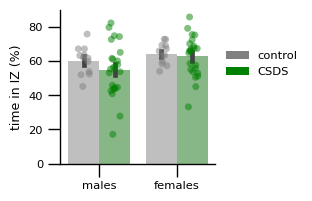

In [14]:
palette = [stress_pal[o] for o in ['control','csds']]

fig, ax = plt.subplots(figsize=(2,2))
sns.barplot(data=SI_df, x='sex', order=['M','F'], y='SI_pct', linewidth=1, 
            errorbar='se', hue='group', hue_order=['Control','CSDS'], palette=palette, alpha=0.5)
sns.stripplot(x='sex', y='SI_pct', data=SI_df, order=['M','F'], jitter=0.15, dodge=True,
              marker='o', size=5, hue='group', hue_order=['Control','CSDS'], palette=palette, 
              alpha=0.5)
plt.ylabel('time in IZ (%)')
plt.xlabel('')
ax.set_xticklabels(['males','females'])

legend_elements = [Patch(facecolor='gray', label='control'),
                   Patch(facecolor='green', label='CSDS')]
plt.legend(handles=legend_elements, bbox_to_anchor=(1,0.8), frameon=False)

sns.despine()
#plt.savefig('./plots/final_figures/SI_time_sex_split.pdf', bbox_inches='tight', dpi=320, facecolor='white')

In [15]:
# Perform ANOVA to test for an effect of sex on SI time
model = ols('SI_pct ~ sex + group + sex:group', data=SI_df).fit()

aov_table = sm.stats.anova_lm(model)
print(aov_table)

             df        sum_sq     mean_sq         F    PR(>F)
sex         1.0    789.104022  789.104022  5.323025  0.024097
group       1.0    207.168044  207.168044  1.397484  0.241263
sex:group   1.0     58.726678   58.726678  0.396150  0.531193
Residual   68.0  10080.560783  148.243541       NaN       NaN


In [16]:
# Make dict that contains mean and std SI pct for each group
groups = ['Control','CSDS']
sexes = ['M','F']

mean_sd = {}
for sex in sexes: 
    mean_sd[sex] = {}
    for group in groups: 
        subset = SI_df.query('group == @group and sex == @sex')
        mean = np.round(subset['SI_pct'].mean(), 2)
        sd = np.round(subset['SI_pct'].std(), 2)

        mean_sd[sex][group] = {'mean': mean, 'sd': sd}

        print(f"{sex} {group} mean: {mean_sd[sex][group]['mean']}")
        print(f"{sex} {group} standard deviation: {mean_sd[sex][group]['sd']}")

M Control mean: 60.23
M Control standard deviation: 8.3
M CSDS mean: 54.71
M CSDS standard deviation: 15.77
F Control mean: 64.29
F Control standard deviation: 6.12
F CSDS mean: 62.61
F CSDS standard deviation: 11.77


In [17]:
# Use sex-specific thresholds for assigning S and R since there is an effect of sex on defeat 
outcome = []
for _, d in SI_df.iterrows():
    group = d['group']
    sex = d['sex']
    if group == 'Control':
        outcome.append('control')
    else:
        threshold = mean_sd[sex]['Control']['mean'] - mean_sd[sex]['Control']['sd']
        if d['SI_pct'] < threshold:
            outcome.append('susceptible')
        else:
            outcome.append('resilient')

SI_df['SI_outcome'] = outcome

                 sum_sq    df          F        PR(>F)
SI_outcome  5819.981487   2.0  37.773759  8.316234e-12
Residual    5315.578041  69.0        NaN           NaN
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1     group2   meandiff p-adj   lower    upper   reject
--------------------------------------------------------------
  control   resilient   4.7778 0.1229  -0.9798  10.5355  False
  control susceptible -17.5586    0.0  -24.114 -11.0033   True
resilient susceptible -22.3364    0.0 -28.6046 -16.0683   True
--------------------------------------------------------------


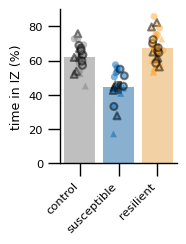

In [22]:
# Figure 1 B (left)
plot_behavior(SI_df, 'SI_pct', 'time in IZ (%)', highlight=True)
plt.savefig('./plots/final_figures/SI_time_all.pdf', bbox_inches='tight', dpi=320)

# Perform stats
model = ols('SI_pct ~ SI_outcome', data=SI_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

tukey_SI = pairwise_tukeyhsd(endog=SI_df['SI_pct'], groups=SI_df['SI_outcome'], alpha=0.05)
print(tukey_SI)

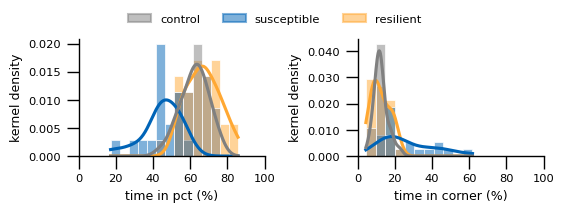

In [15]:
# Figure S1C
measurements = ['SI_pct','SI_corner_pct']
        
fig, ax = plt.subplots(1, 2, figsize=(6,1.7))
plt.subplots_adjust(wspace=0.5, top=0.8)

for i,meas in enumerate(measurements):
    sns.histplot(
        x=meas, hue='SI_outcome', data=SI_df, kde=True, binwidth=5, stat="density",
        linewidth=0.5, fill=True, hue_order=outcomes, alpha=0.5, edgecolor="white", 
        palette=[sr_pal[outcome] for outcome in outcomes], ax=ax[i])

    ax[i].set_xlabel(f'time in {meas.split("_")[1]} (%)')
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax[i].set_xlim(0, 100)
    ax[i].set_ylabel('kernel density')

legend_elements = [
    Patch(facecolor=sr_pal[outcome], alpha=0.5, edgecolor=sr_pal[outcome], 
    label=outcome) for outcome in outcomes]
                  
ax[0].legend([], frameon=False)
plt.legend(handles=legend_elements, bbox_to_anchor=(0.4,1.3), frameon=False, ncol=3)

sns.despine()
plt.savefig('./plots/final_figures/SI_histplot.pdf', bbox_inches='tight', dpi=320)

                 sum_sq    df          F        PR(>F)
SI_outcome  2875.692858   2.0  21.693114  4.905597e-08
Residual    4573.405340  69.0        NaN           NaN
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
  control   resilient  -0.0162   1.0 -5.3568  5.3243  False
  control susceptible   14.586   0.0  8.5055 20.6665   True
resilient susceptible  14.6022   0.0  8.7881 20.4163   True
-----------------------------------------------------------


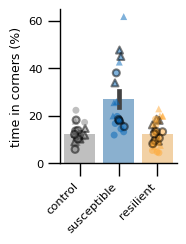

In [23]:
# Figure 1B (right) 
plot_behavior(SI_df, 'SI_corner_pct', 'time in corners (%)', highlight=True)
plt.savefig('./plots/final_figures/SI_corner_time.pdf', bbox_inches='tight', dpi=320)

# Perform stats
model = ols('SI_corner_pct ~ SI_outcome', data=SI_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

tukey_SI = pairwise_tukeyhsd(endog=SI_df['SI_corner_pct'], groups=SI_df['SI_outcome'], alpha=0.05)
print(tukey_SI)

                 sum_sq    df          F    PR(>F)
SI_outcome  1700.852004   2.0  11.653536  0.000044
Residual    5035.329561  69.0        NaN       NaN
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
  control   resilient   3.8133   0.24 -1.7905  9.4171  False
  control susceptible  12.6839    0.0  6.3037 19.0641   True
resilient susceptible   8.8706 0.0025  2.7699 14.9712   True
------------------------------------------------------------


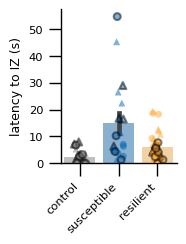

In [24]:
# Figure S1D
plot_behavior(SI_df, 'SI_latency_to_IZ', 'latency to IZ (s)', highlight=True)
plt.savefig('./plots/final_figures/SI_latency_to_IZ.pdf', bbox_inches='tight', dpi=320)

# Perform stats
model = ols('SI_latency_to_IZ ~ SI_outcome', data=SI_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

tukey_SI = pairwise_tukeyhsd(endog=SI_df['SI_latency_to_IZ'], groups=SI_df['SI_outcome'], alpha=0.05)
print(tukey_SI)

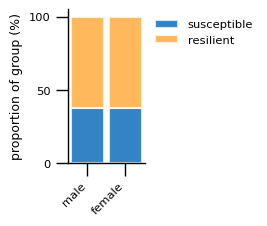

In [18]:
# Figure S1E

# Get total, susceptible, and resilient counts by sex
csds_counts = SI_df.query('group == "CSDS"').groupby(['sex', 'SI_outcome']).size().unstack(fill_value=0)
totals = SI_df.query('group == "CSDS"').groupby('sex').size()

# Calculate percentages
susBars = (csds_counts.get('susceptible', 0) / totals * 100).reindex(['M', 'F'])
resBars = (csds_counts.get('resilient', 0) / totals * 100).reindex(['M', 'F'])

fig, ax = plt.subplots(figsize=(1, 2))
positions = range(len(susBars))
ax.bar(positions, susBars, color=sr_pal['susceptible'], alpha=0.8, edgecolor='white', width=0.85, label='susceptible')
ax.bar(positions, resBars, bottom=susBars, color=sr_pal['resilient'], alpha=0.8, edgecolor='white', width=0.85, label='resilient')
ax.set_xticks(positions)
ax.set_xticklabels(['male', 'female'], rotation=45, ha='right')
ax.set_yticks([0, 50, 100])
ax.set_ylabel("proportion of group (%)")
sns.despine()
plt.legend(frameon=False, bbox_to_anchor=(1, 1))
plt.savefig('./plots/final_figures/percent_SR_by_sex.pdf', bbox_inches='tight', dpi=320)

### OFT

In [25]:
# Load data from all cohorts and put them together into one df
OFT_paths = [
    '../../Ethovision/M_defeat_11-2021/OFT_11-21-2021/Statistics-OFT_11-21-2021.csv',
    '../../Ethovision/F_defeat_12-2021/OFT_12-10-2021/Statistics-OFT_12-10-2021.csv',
    '../../Ethovision/M_defeat_2-2022/OFT_2-11-2022/Statistics-OFT_2-11-2022.csv',
    '../../Ethovision/F_defeat_3-2022/OFT_3-7-2022/Statistics-OFT_3-7-2022.csv']

OFT_df = pd.DataFrame()
for i,path in enumerate(OFT_paths):
    df = load_OFT(path,i+1)
    OFT_df = pd.concat([OFT_df, df], ignore_index=True)

In [26]:
# Merge SI data with OFT data
total_df = pd.merge(SI_df, OFT_df, on=['cohort','mouse','group','sex'], how='outer')

                  sum_sq    df         F    PR(>F)
SI_outcome   2699.050000   2.0  5.596569  0.005592
Residual    16638.269444  69.0       NaN       NaN
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower    upper  reject
-------------------------------------------------------------
  control   resilient -12.3083 0.0139 -22.4948 -2.1219   True
  control susceptible -13.9306 0.0146 -25.5283 -2.3328   True
resilient susceptible  -1.6222 0.9346 -12.7118  9.4674  False
-------------------------------------------------------------


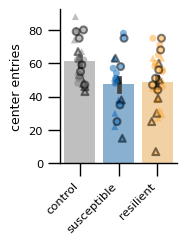

In [28]:
# Figure S1G
plot_behavior(total_df, 'OFT_center_freq', 'center entries', highlight=True)
plt.savefig('./plots/final_figures/OFT_center_entries.pdf', bbox_inches='tight', dpi=320)

# Perform stats
model = ols('OFT_center_freq ~ SI_outcome', data=total_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

tukey_SI_corner = pairwise_tukeyhsd(endog=total_df['OFT_center_freq'], groups=total_df['SI_outcome'], alpha=0.05)
print(tukey_SI_corner)

                 sum_sq    df        F    PR(>F)
SI_outcome   381.763975   2.0  2.41682  0.096721
Residual    5449.664148  69.0      NaN       NaN


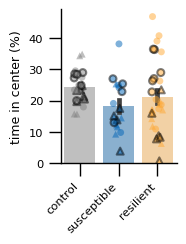

In [29]:
plot_behavior(total_df, 'OFT_center_pct', 'time in center (%)', highlight=True)
plt.savefig('./plots/final_figures/OFT_center_time.pdf', bbox_inches='tight', dpi=320)

# Perform stats
model = ols('OFT_center_pct ~ SI_outcome', data=total_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

                 sum_sq    df         F    PR(>F)
SI_outcome   932.855408   2.0  3.903626  0.024769
Residual    8244.518209  69.0       NaN       NaN
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
  control   resilient   4.6159 0.2779 -2.5547 11.7864  False
  control susceptible   9.4967 0.0186  1.3327 17.6607   True
resilient susceptible   4.8808 0.2983 -2.9254 12.6871  False
------------------------------------------------------------


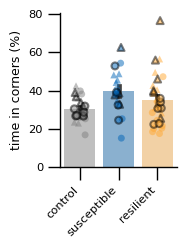

In [31]:
# Figure S1H
plot_behavior(total_df, 'OFT_corner_pct', 'time in corners (%)', highlight=True)
plt.savefig('./plots/final_figures/OFT_corner_time.pdf', bbox_inches='tight', dpi=320)

# Perform stats
model = ols('OFT_corner_pct ~ SI_outcome', data=total_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

tukey_SI_corner = pairwise_tukeyhsd(endog=total_df['OFT_corner_pct'], groups=total_df['SI_outcome'], alpha=0.05)
print(tukey_SI_corner)


                  sum_sq    df         F    PR(>F)
SI_outcome    837.897222   2.0  2.365953  0.101433
Residual    12218.102778  69.0       NaN       NaN


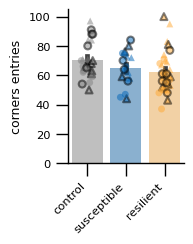

In [32]:
plot_behavior(total_df, 'OFT_corner_freq', 'corners entries', highlight=True)
plt.savefig('./plots/final_figures/OFT_corner_entries.pdf', bbox_inches='tight', dpi=320)

# Perform stats
model = ols('OFT_corner_freq ~ SI_outcome', data=total_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

                  sum_sq    df         F   PR(>F)
SI_outcome   7476.776151   2.0  3.261405  0.04432
Residual    79091.303840  69.0       NaN      NaN
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower    upper  reject
-------------------------------------------------------------
  control   resilient    12.81 0.3561  -9.3992 35.0192  False
  control susceptible  26.9097 0.0344   1.6235  52.196   True
resilient susceptible  14.0997 0.3482 -10.0786  38.278  False
-------------------------------------------------------------


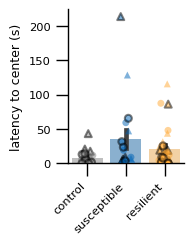

In [33]:
# Figure S1I
 
plot_behavior(total_df, 'OFT_latency_to_center', 'latency to center (s)', highlight=True)
plt.savefig('./plots/final_figures/OFT_latency_to_center.pdf', bbox_inches='tight', dpi=320)

# Perform stats
model = ols('OFT_latency_to_center ~ SI_outcome', data=total_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

tukey_SI_corner = pairwise_tukeyhsd(endog=total_df['OFT_latency_to_center'], groups=total_df['SI_outcome'], alpha=0.05)
print(tukey_SI_corner)

### EPM

In [34]:
# Load data from all cohorts and put them together into one df
EPM_paths = [
    '../../Ethovision/M_defeat_11-2021/EPM_11-23-2021/Statistics-EPM_11-23-2021.csv',
    '../../Ethovision/F_defeat_12-2021/EPM_12-11-2021/Statistics-EPM_12-11-2021.csv',
    '../../Ethovision/M_defeat_2-2022/EPM_2-12-2022/Statistics-EPM_2-12-2022.csv',
    '../../Ethovision/F_defeat_3-2022/EPM_3-8-2022/Statistics-EPM_3-8-2022.csv']

EPM_df = pd.DataFrame()
for i,path in enumerate(EPM_paths):
    df = load_EPM(path,i+1)
    EPM_df = pd.concat([EPM_df, df], ignore_index=True)

In [35]:
# Merge EPM data with SI and OFT data
total_df = pd.merge(total_df, EPM_df, on=['cohort','mouse','group','sex'], how='outer')

                sum_sq    df         F    PR(>F)
SI_outcome  246.919738   2.0  9.292528  0.000267
Residual    916.729088  69.0       NaN       NaN
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
  control   resilient  -3.3955 0.0032 -5.7865 -1.0044   True
  control susceptible  -4.5138 0.0005 -7.2361 -1.7915   True
resilient susceptible  -1.1183 0.5612 -3.7214  1.4847  False
------------------------------------------------------------


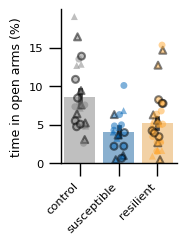

In [39]:
# Figure S1K
plot_behavior(total_df, 'EPM_open_arm_pct', 'time in open arms (%)', highlight=True)
plt.savefig('./plots/final_figures/EPM_open_arm_time.pdf', bbox_inches='tight', dpi=320)

# Perform stats
model = ols('EPM_open_arm_pct ~ SI_outcome', data=total_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

tukey_EPM = pairwise_tukeyhsd(endog=total_df['EPM_open_arm_pct'], groups=total_df['SI_outcome'], alpha=0.05)
print(tukey_EPM)

                sum_sq    df         F  PR(>F)
SI_outcome  128.430556   2.0  4.892893  0.0103
Residual    905.569444  69.0       NaN     NaN
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
  control   resilient  -1.7917 0.1752 -4.1681  0.5848  False
  control susceptible  -3.5139 0.0076 -6.2196 -0.8082   True
resilient susceptible  -1.7222 0.2548 -4.3094  0.8649  False
------------------------------------------------------------


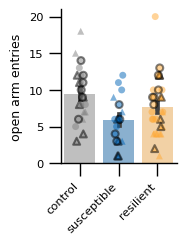

In [40]:
# Figure S1L
plot_behavior(total_df, 'EPM_open_arm_freq', 'open arm entries', highlight=True)
plt.savefig('./plots/final_figures/EPM_open_arm_entries.pdf', bbox_inches='tight', dpi=320)

# Perform stats
model = ols('EPM_open_arm_freq ~ SI_outcome', data=total_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

tukey_EPM = pairwise_tukeyhsd(endog=total_df['EPM_open_arm_freq'], groups=total_df['SI_outcome'], alpha=0.05)
print(tukey_EPM)

                   sum_sq    df         F    PR(>F)
SI_outcome   43858.033477   2.0  3.699229  0.029777
Residual    409031.809023  69.0       NaN       NaN
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1     group2   meandiff p-adj   lower    upper   reject
--------------------------------------------------------------
  control   resilient   43.336 0.1069  -7.1704  93.8425  False
  control susceptible  61.4108 0.0336   3.9067 118.9149   True
resilient susceptible  18.0747  0.712 -36.9097  73.0592  False
--------------------------------------------------------------


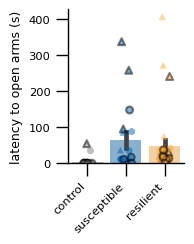

In [41]:
# Figure S1M
plot_behavior(total_df, 'EPM_latency_to_open_arms', 'latency to open arms (s)', highlight=True)
plt.savefig('./plots/final_figures/EPM_latency_to_open_arms.pdf', bbox_inches='tight', dpi=320)

# Perform stats
model = ols('EPM_latency_to_open_arms ~ SI_outcome', data=total_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

tukey_EPM = pairwise_tukeyhsd(endog=total_df['EPM_latency_to_open_arms'], groups=total_df['SI_outcome'], alpha=0.05)
print(tukey_EPM)

### Correlations across tests

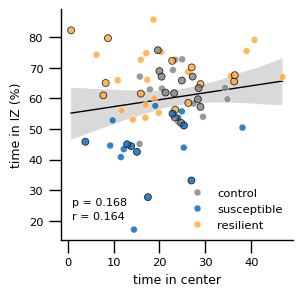

In [46]:
# Figure S1N
fig, ax = plt.subplots(figsize=(3,3))

# Compute correlation
r, p = scipy.stats.pearsonr(np.array(total_df['SI_pct']), 
                            np.array(total_df['OFT_center_pct']))  

sns.regplot(data=total_df, y='SI_pct', x='OFT_center_pct', color='black', 
            scatter=False, line_kws={'linewidth':1}, ax=ax)

# Split data by sequenced and not sequenced animals for highlighting
unseq = total_df.query('sequenced == False')
seq = total_df.query('sequenced == True')

# Plot unsequenced animals
sns.scatterplot(data=unseq, y='SI_pct', x='OFT_center_pct', ax=ax, 
                hue='SI_outcome', hue_order=['control','susceptible','resilient'], 
                marker='o', s=25, alpha=0.8, zorder=3,
                palette=[sr_pal['control'],sr_pal['susceptible'],sr_pal['resilient']]) 

# Plot sequenced animals
sns.scatterplot(data=seq, y='SI_pct', x='OFT_center_pct', ax=ax, legend=False,
                hue='SI_outcome', hue_order=['control','susceptible','resilient'], 
                marker='o', s=25, alpha=0.8, edgecolor='black', linewidth=0.6, zorder=4,
                palette=[sr_pal['control'],sr_pal['susceptible'],sr_pal['resilient']])

plt.xlabel('time in center')
plt.ylabel('time in IZ (%)')
plt.legend(frameon=False)
sns.despine()

plt.text(1,20.5,'r = %s'%(np.round(r,3)), size=8)
plt.text(1,25,'p = %s'%(np.round(p,3)), size=8);

plt.savefig('./plots/final_figures/SI_OFT_center_time_correlation.pdf', bbox_inches='tight', dpi=320)

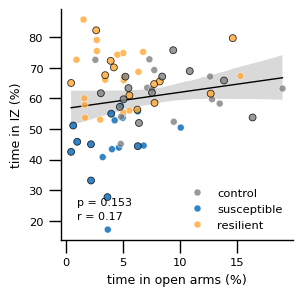

In [47]:
# Figure S1O
fig, ax = plt.subplots(figsize=(3,3))

# Compute correlation
r, p = scipy.stats.pearsonr(np.array(total_df['SI_pct']), 
                            np.array(total_df['EPM_open_arm_pct']))  

sns.regplot(data=total_df, y='SI_pct', x='EPM_open_arm_pct', color='black', 
            scatter=False, line_kws={'linewidth':1}, ax=ax)

# Split data by sequenced and not sequenced animals for highlighting
unseq = total_df.query('sequenced == False')
seq = total_df.query('sequenced == True')

# Plot unsequenced animals
sns.scatterplot(data=unseq, y='SI_pct', x='EPM_open_arm_pct', ax=ax, 
                hue='SI_outcome', hue_order=['control','susceptible','resilient'], 
                marker='o', s=25, alpha=0.8, zorder=3,
                palette=[sr_pal['control'],sr_pal['susceptible'],sr_pal['resilient']]) 

# Plot sequenced animals 
sns.scatterplot(data=seq, y='SI_pct', x='EPM_open_arm_pct', ax=ax, legend=False,
                hue='SI_outcome', hue_order=['control','susceptible','resilient'], 
                marker='o', s=25, alpha=0.8, edgecolor='black', linewidth=0.6, zorder=4,
                palette=[sr_pal['control'],sr_pal['susceptible'],sr_pal['resilient']])

plt.xlabel('time in open arms (%)')
plt.ylabel('time in IZ (%)')
plt.legend(frameon=False)
sns.despine()

plt.text(1,20.5,'r = %s'%(np.round(r,3)), size=8)
plt.text(1,25,'p = %s'%(np.round(p,3)), size=8);

plt.savefig('./plots/final_figures/SI_EPM_correlation.pdf', bbox_inches='tight', dpi=320)


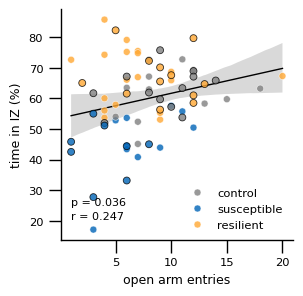

In [49]:
# Figure S1P
fig, ax = plt.subplots(figsize=(3,3))

# Compute correlation
r, p = scipy.stats.pearsonr(np.array(total_df['SI_pct']), 
                            np.array(total_df['EPM_open_arm_freq']))  

sns.regplot(data=total_df, y='SI_pct', x='EPM_open_arm_freq', color='black', 
            scatter=False, line_kws={'linewidth':1}, ax=ax)

# Split data by sequenced and not sequenced animals for highlighting
unseq = total_df.query('sequenced == False')
seq = total_df.query('sequenced == True')

# Plot unsequenced animals 
sns.scatterplot(data=unseq, y='SI_pct', x='EPM_open_arm_freq', ax=ax, 
                hue='SI_outcome', hue_order=['control','susceptible','resilient'], 
                marker='o', s=25, alpha=0.8, zorder=3,
                palette=[sr_pal['control'], sr_pal['susceptible'], sr_pal['resilient']])

# Plot sequenced animals 
sns.scatterplot(data=seq, y='SI_pct', x='EPM_open_arm_freq', ax=ax, legend=False,
                hue='SI_outcome', hue_order=['control','susceptible','resilient'], 
                marker='o', s=25, alpha=0.8, edgecolor='black', linewidth=0.6, zorder=4,
                palette=[sr_pal['control'], sr_pal['susceptible'], sr_pal['resilient']])

plt.xlabel('open arm entries')
plt.ylabel('time in IZ (%)')
plt.legend(frameon=False)
sns.despine()

plt.text(1, 20.5, 'r = %s' % (np.round(r, 3)), size=8)
plt.text(1, 25, 'p = %s' % (np.round(p, 3)), size=8)

plt.savefig('./plots/final_figures/SI_EPM_open_entries_correlation.pdf', 
            bbox_inches='tight', dpi=320)